In [4]:
import torch
from torchmetrics.classification import MultilabelAUROC

# Suppose we have 3 labels (num_labels=3).
# We'll simulate predictions ("preds") for 5 samples, each with 3 label probabilities.
# We'll also simulate target labels ("target"), where one label (class 2) never appears
# in the positive set, illustrating the missing-class scenario.

preds = torch.tensor([
    [0.7,  0.1,  0.05],  # sample 1
    [0.4,  0.9,  0.02],  # sample 2
    [0.8,  0.2,  0.01],  # sample 3
    [0.1,  0.7,  0.03],  # sample 4
    [0.6,  0.8,  0.00],  # sample 5
])

# Each row is a single sample's ground truth for 3 labels.
# For instance, target[i, j] = 1 means sample i is positive for class j.
# Notice all entries for class 2 (last column) are zero => no positive samples for that class.
target = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [1, 0, 0],
    [0, 1, 0],
    [1, 1, 0],
])

# Initialize the MultilabelAUROC metric.
# average='macro' -> The metric averages AUROCs across classes equally.
metric = MultilabelAUROC(num_labels=3, average='macro')

# Compute AUROC over these 5 samples
score = metric(preds, target)
print(f"Multilabel (macro) AUROC: {score}")

Multilabel (macro) AUROC: 0.6666666865348816


In [4]:
from datasets import load_from_disk

ds = load_from_disk("/home/lrauch/projects/birdMAE/data/audioset_balanced/audioset_balanced_prepared")

Loading dataset from disk:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

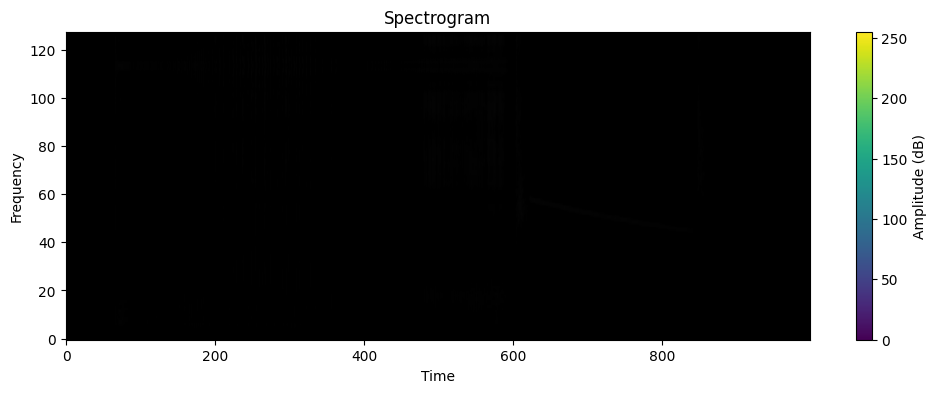

In [10]:
import matplotlib.pyplot as plt

sample = ds["train"][100]
plt.figure(figsize=(12, 4))
plt.imshow(sample["input_values"], aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Amplitude (dB)')
plt.show()

In [ ]:
from torchaudio.compliance.kaldi import fbank
import torch 
import numpy as np
from PIL import Image

def prepare_dataset(batch, label_key="human_labels", sample_frequency=32_000):
    data = [torch.from_numpy(b["array"]) for b in batch["audio"]]

    imgs = []
    for d in data: 
        img = fbank(
            d.unsqueeze(0),
            htk_compat=True,
            sample_frequency=sample_frequency,
            use_energy=False,
            window_type='hanning',
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10
        )
        imgs.append(img.T) # after .T: width, height
    imgs = [Image.fromarray(img.numpy()) for img in imgs]
    
    batch['input_values'] = imgs
    batch["label"] = batch[label_key]

    return batch

def get_prepare_dataset_fn(label_key="human_labels", sample_frequency=32_000):
    return lambda batch: prepare_dataset(batch, label_key, sample_frequency)

In [11]:
from datasets import load_dataset
from datasets import Audio, load_dataset, Sequence, ClassLabel

dataset = load_dataset(
    "agkphysics/AudioSet", 
    cache_dir="/home/lrauch/projects/birdMAE/data/audioset_balanced")

dataset = dataset.cast_column("audio", Audio(sampling_rate=32_000, decode=False))

: 

In [2]:
from datasets import load_from_disk, Audio
ds = load_from_disk("/home/lrauch/projects/birdMAE/data/audioset_balanced/saved_to_disk")

Loading dataset from disk:   0%|          | 0/53 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/48 [00:00<?, ?it/s]

In [3]:
ds = ds.cast_column("audio", Audio(sampling_rate=32_000, decode=True))

Spectrogram shape: torch.Size([998, 128])


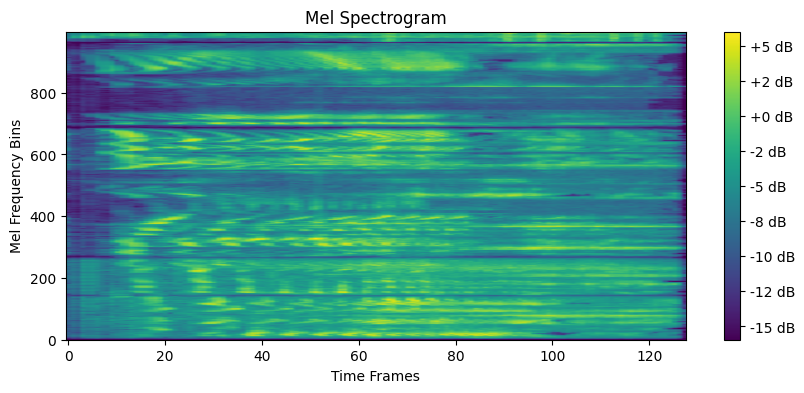

Spectrogram shape: torch.Size([998, 128])


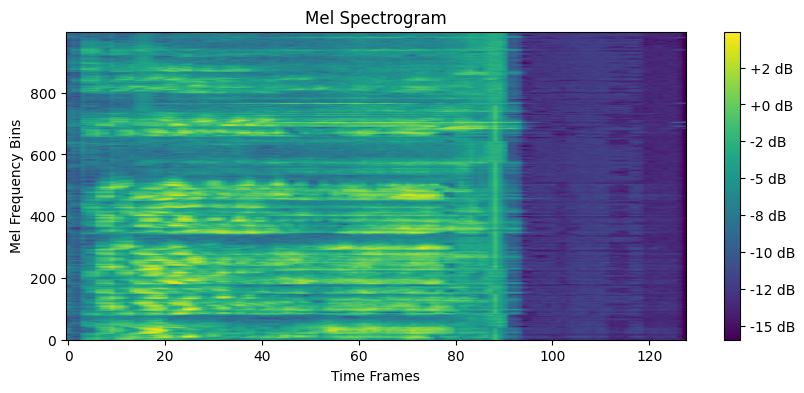

Spectrogram shape: torch.Size([998, 128])


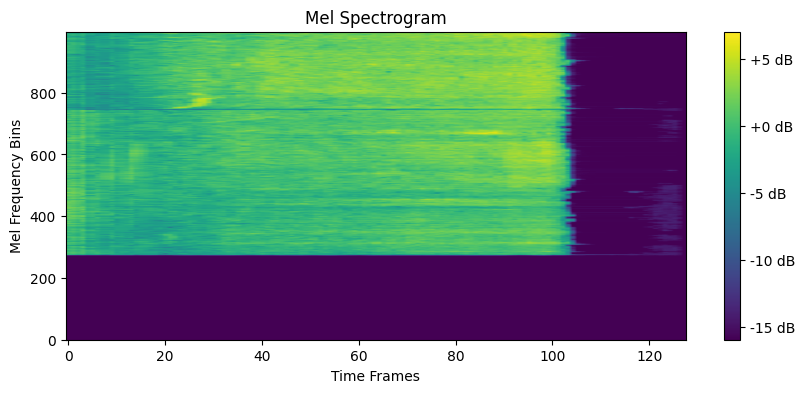

Spectrogram shape: torch.Size([998, 128])


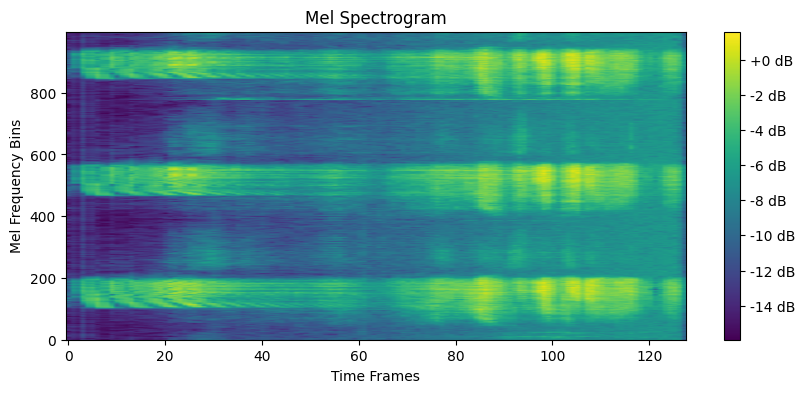

Spectrogram shape: torch.Size([998, 128])


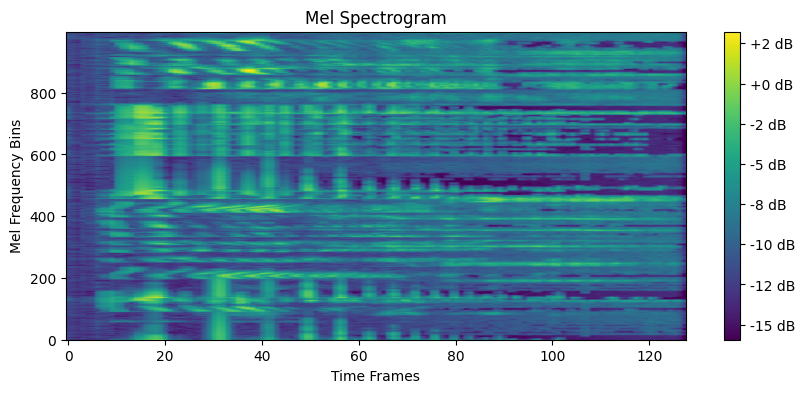

In [7]:
from torchaudio.compliance.kaldi import fbank
import torch 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
for i in np.random.choice(len(ds["train"]), size=5, replace=False):
    i = int(i)
    # Get audio data
    audio_data = ds["train"][i]["audio"]["array"]
    sample_rate = ds["train"][i]["audio"]["sampling_rate"]
    
    # Create audio player widget
    from IPython.display import Audio, display
    display(Audio(audio_data, rate=sample_rate))
    
    # Generate mel spectrogram
    img = fbank(
        torch.from_numpy(audio_data).unsqueeze(0),
        htk_compat=True,
        sample_frequency=32_000,
        use_energy=False,
        window_type='hanning',
        num_mel_bins=128,
        dither=0.0,
        frame_shift=10
    )

    print(f"Spectrogram shape: {img.shape}")  # Print the actual dimensions
    plt.figure(figsize=(10, 4))
    plt.imshow(img, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')
    plt.show()

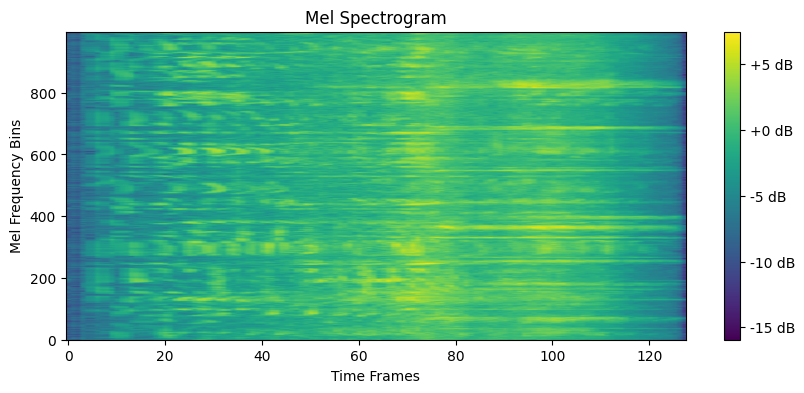